In this famous Kaggle we are trying to predict if a passenger of the titanic would have survived the disaster based on different features such as age, sex, cabine fare and number of siblings. The training dataset contains about 900 rows. As ruled by Kaggle, we will use the AUC area under the ROC curve in order to assess the performance of our model.

In [203]:
#Import packages
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import RFE
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [204]:
#Check python version and env
print(sys.version)

3.12.4 | packaged by Anaconda, Inc. | (main, Jun 18 2024, 10:14:12) [Clang 14.0.6 ]


In [227]:
#Pull data from file
df_train = pd.read_csv('titanic_train.csv')
df_test = pd.read_csv('titanic_test.csv')

In [228]:
#Pull features for train dataset
df_train.columns
len(df_submission)

418

In [229]:
#Pull features for submission dataset
df_train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

## STEP 1 : APPROACH WITH FUNCTIONS

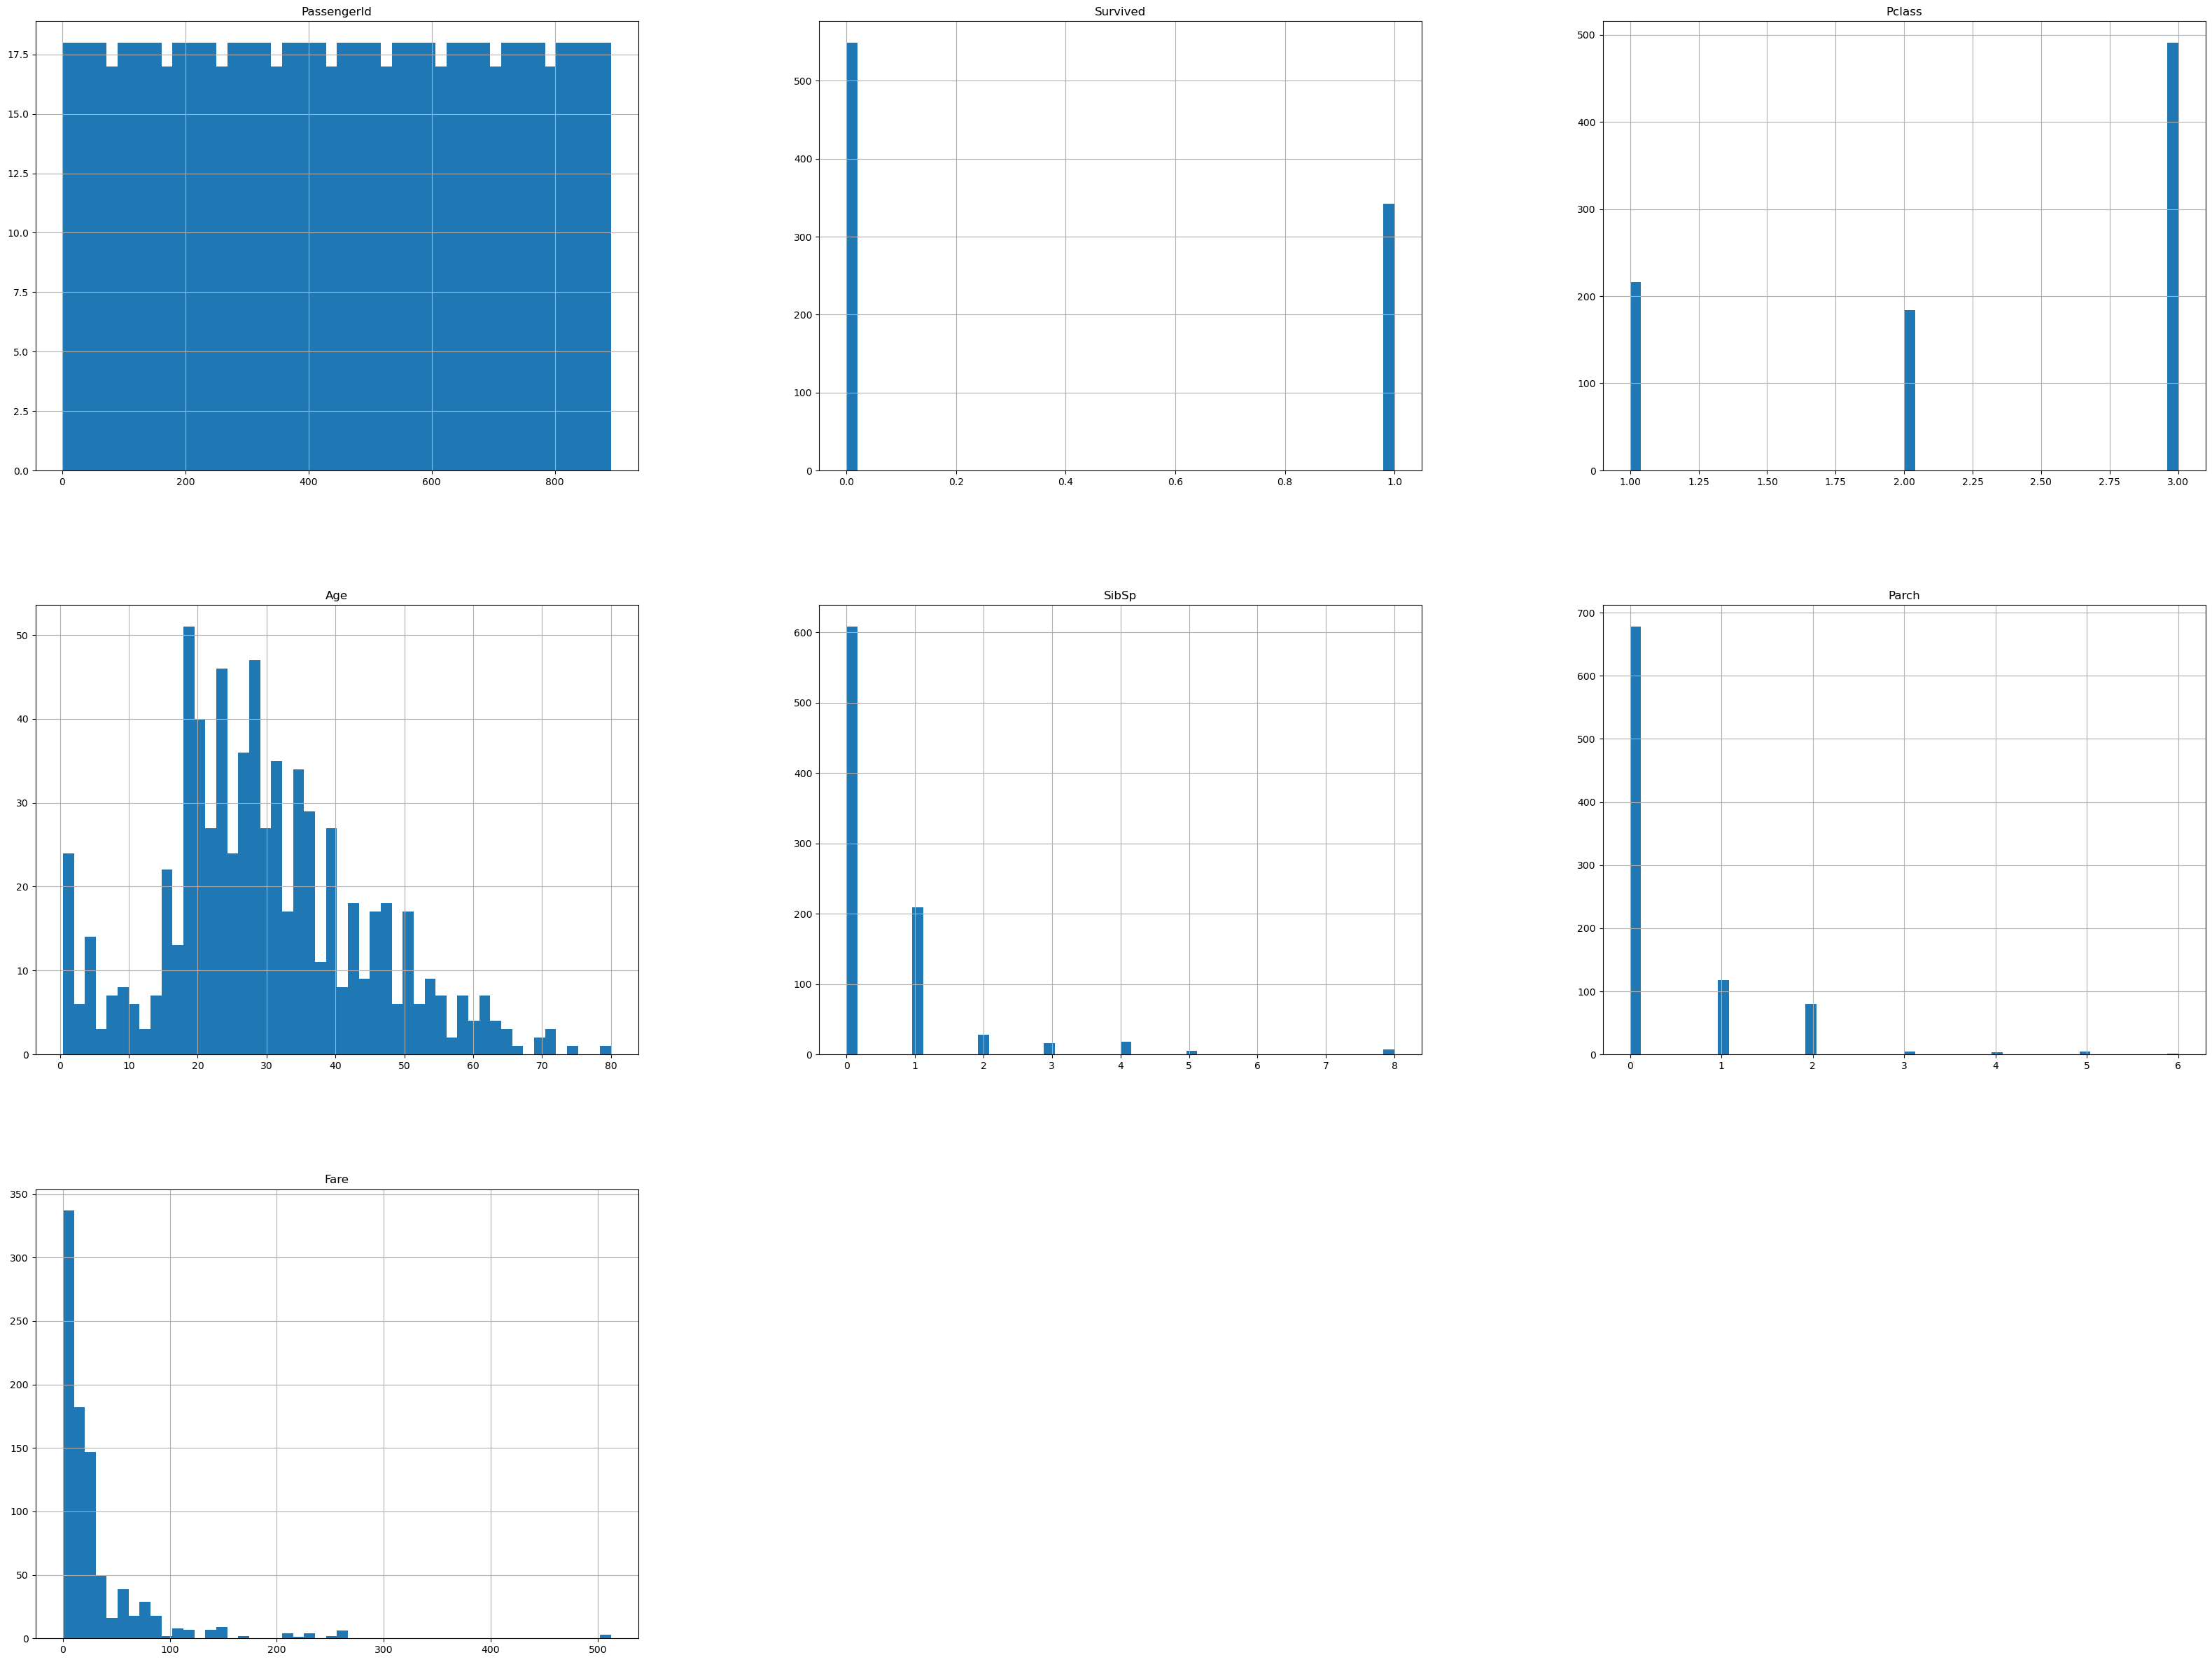

In [230]:
#Explore the data
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
df_train.hist(bins=50, figsize=(40,30))
plt.show()

In [231]:
#Define numerical and categorical features
categorical_cols = [col for col in df_train.columns if df_train[col].dtype == 'object']
numerical_cols = [col for col in df_train.columns if df_train[col].dtype != 'object']

             PassengerId  Survived    Pclass       Age     SibSp     Parch  \
PassengerId     1.000000 -0.005007 -0.035144  0.036847 -0.057527 -0.001652   
Survived       -0.005007  1.000000 -0.338481 -0.077221 -0.035322  0.081629   
Pclass         -0.035144 -0.338481  1.000000 -0.369226  0.083081  0.018443   
Age             0.036847 -0.077221 -0.369226  1.000000 -0.308247 -0.189119   
SibSp          -0.057527 -0.035322  0.083081 -0.308247  1.000000  0.414838   
Parch          -0.001652  0.081629  0.018443 -0.189119  0.414838  1.000000   
Fare            0.012658  0.257307 -0.549500  0.096067  0.159651  0.216225   

                 Fare  
PassengerId  0.012658  
Survived     0.257307  
Pclass      -0.549500  
Age          0.096067  
SibSp        0.159651  
Parch        0.216225  
Fare         1.000000  


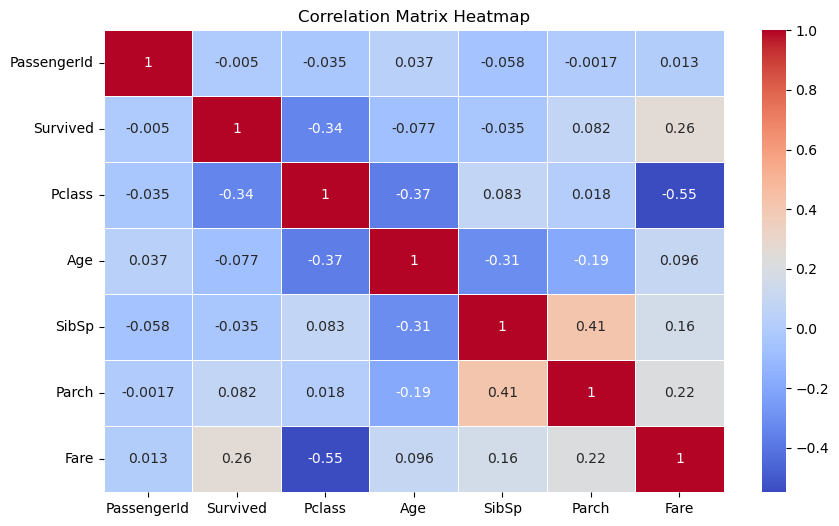

In [232]:
#Create correlation matrix
corr_matrix = df_train[numerical_cols].corr()
print(corr_matrix)
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

Fare and Pclass seems to have a high influence on the survival rate - Parch and Age following

In [233]:
#Clean data and engineer the features
def preprocessing_data(X):
    
    #names seem hard to use - we can flag mrs-mr and mme
    List=[]
    for i in range(0,len(X["Name"])):
        if 'Miss' in X["Name"][i]:
            List.append('Miss')
        elif 'Mrs' in X["Name"][i]:
            List.append('Mrs')
        else :
            List.append('Mr')
    X["Title"] = List
    #encoding mr, mrs and miss
    X["Title_encoded"], Name_categories = X['Title'].factorize()

    #encode age sex
    X['Sex_encoded'] = np.where(X['Sex'] == 'male', 1,0)
    
    #missing age - replace by average
    mean_age = X['Age'].mean()
    X['Age'].fillna(value = mean_age, inplace = True)
    #missing port (2 out of 891) - replace by S since majority
    X['Embarked'].fillna(value = 'S', inplace=True)
    
    
    #rescale - two methods Min Max or Standarization 
    mean_fare = X["Fare"].mean()
    std_fare = X["Fare"].std()
    X['Fare_standarized'] = (X["Fare"] - mean_fare)/std_fare
    mean_fare_std = X['Fare_standarized'].mean()
    X['Fare_standarized'].fillna(value = mean_fare_std,inplace = True)
    
    #good but not perfect since the distance is equal between the 3 ports (0,1,2)
    Embarked_encoded, Embarked_categories = X['Embarked'].factorize()
    
    #one hot encoder - create 3 columns with binary value for each port
    from sklearn.preprocessing import OneHotEncoder
    cat_encoder = OneHotEncoder()
    Embarked_encoded_1hot = cat_encoder.fit_transform(Embarked_encoded.reshape(-1,1))
    Embarked_encoded_1hot
    Embarked_encoded_1hot_df = pd.DataFrame(Embarked_encoded_1hot.toarray(),columns=['Port_S','Port_C','Port_Q'])
    
    #create a new column - number member family
    X['Members_family'] = X['SibSp'] + X['Parch']
    pd.concat([X,Embarked_encoded_1hot_df],axis = 1)
    
    #we can see that Pclass,Fare,Title_Encoded,Sex_encoded are highly influent - Age, SibSp and Parch is less but we will keep them in the model
    #cabine has a lot of null values -- probably going to remove this column
    #name is useless now - same as ticket
    #fare can be removed since we made standardization 
    #it seems like Members_family does make lot of influence - less infl than SibSp or Parch 
    X.drop(columns = ['Name','Cabin','Ticket','Fare','Embarked','Sex','Members_family','Title'],inplace = True)
    
    #create final dataset for training and remove label
    X.drop(columns = ['PassengerId'],inplace = True)

#Apply preprocessing function to training data
preprocessing_data(df_train)
X_train = df_train 
y_train = df_train['Survived']
df_train.drop(columns = ['Survived'],inplace = True)

#Apply preprocessing function to testing data
preprocessing_data(df_test)
X_test = df_test
y_test = submission_file['Survived']

/var/folders/sw/5v7lnbt97qn024bq0txyyb0h0000gn/T/ipykernel_32668/3406463608.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X['Age'].fillna(value = mean_age, inplace = True)
/var/folders/sw/5v7lnbt97qn024bq0txyyb0h0000gn/T/ipykernel_32668/3406463608.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values a

In [235]:
#Train different models

##Logistic Regression
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression()
log_reg.fit(X_train,y_train)
scores_log = cross_val_score(log_reg, X_train, y_train, cv=5, scoring="accuracy")
print(scores_log.mean())

##Decision Tree
from sklearn.tree import DecisionTreeClassifier
tree_clf = DecisionTreeClassifier(max_depth=3, random_state=42)
tree_clf.fit(X_train, y_train)
scores_tree = cross_val_score(tree_clf, X_train, y_train, cv=5, scoring="accuracy")
print(scores_tree.mean())

##Random Forest
from sklearn.ensemble import RandomForestClassifier
rnd_clf = RandomForestClassifier(n_estimators=10, max_depth = 3, random_state=42)
rnd_clf.fit(X_train, y_train)
scores_rnd = cross_val_score(rnd_clf, X_train, y_train, cv=5, scoring="accuracy")
print(scores_rnd.mean())

##SVC 
from sklearn.svm import SVC
from sklearn import datasets
svm_clf = SVC(kernel="linear", C=10)
svm_clf.fit(X_train, y_train)
scores_svm = cross_val_score(svm_clf, X_train, y_train, cv=5, scoring="accuracy")
print(scores_svm.mean())

##Voting clasifier 
from sklearn.ensemble import VotingClassifier
voting_clf = VotingClassifier(estimators=[('svm', svm_clf), ('rf', rnd_clf), ('lg', log_reg)],voting='hard')
voting_clf.fit(X_train, y_train)
scores_voting_clf = cross_val_score(voting_clf, X_train, y_train, cv=5, scoring="accuracy")
print(scores_voting_clf.mean())

##Xgboost classifier
from xgboost import XGBClassifier
xgb = XGBClassifier(verbose = '-1')
xgb.fit(X_train, y_train)
scores_xgb = cross_val_score(xgb, X_train, y_train, cv=5, scoring="accuracy")
print(scores_xgb.mean())

##LGBM classifier
from lightgbm import LGBMClassifier
lgbm = LGBMClassifier(verbose = '-1')
lgbm.fit(X_train, y_train)
scores_lgbm = cross_val_score(lgbm, X_train, y_train, cv=5, scoring="accuracy")
print(scores_lgbm.mean())

/opt/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.786761659657272
0.8103195028560668
0.795712761283033
0.788977465319189


/opt/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/miniconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [23:24:37] WARNING: /var/folders/c_/qfmhj66j0tn016nkx_th4hxm0000gp/T/abs_b6qk1lz_ug/croot/xgboost-split_1724073748391/work/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/miniconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [23:24:37] WARNING: /var/folders/c_/qfmhj66j0tn016nkx_th4hxm0000gp/T/abs_b6qk1lz_ug/croot/xgboost-split_17

0.7934718473416609


/opt/miniconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [23:24:37] WARNING: /var/folders/c_/qfmhj66j0tn016nkx_th4hxm0000gp/T/abs_b6qk1lz_ug/croot/xgboost-split_1724073748391/work/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


0.82045069361622
0.8238403113426651


The models which perform the best in terms of accuracy on training data is in order the lgbm, the xgb, the decision tree, the random forest, the voting classifier, the logistic regression and the svm.

## STEP 2 : APPROACH WITH DATA PIPELINES

In [224]:
#Pull data from file
df_train = pd.read_csv('titanic_train.csv')
df_test = pd.read_csv('titanic_test.csv')
submission_file = pd.read_csv('titanic_submission.csv')

#Apply preprocessing function to training data
X_train = df_train 
y_train = df_train['Survived']
X_train.drop(columns = ['Survived'],inplace = True)

#Apply preprocessing function to testing data
X_test = df_test

In [225]:
#Create a class to select numerical or categorical columns 
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

#Fill NA with median for numerical values
try:
    from sklearn.impute import SimpleImputer # Scikit-Learn 0.20+
except ImportError:
    from sklearn.preprocessing import Imputer as SimpleImputer

imputer = SimpleImputer(strategy="median")    

#Create title features for X_train and X_test
List_train=[]
for i in range(0,len(X_train["Name"])):
    if 'Miss' in X_train["Name"][i]:
        List_train.append('Miss')
    elif 'Mrs' in X_train["Name"][i]:
        List_train.append('Mrs')
    else :
        List_train.append('Mr')
X_train["Title"] = List_train

List_test=[]
for i in range(0,len(X_test["Name"])):
    if 'Miss' in X_test["Name"][i]:
        List_test.append('Miss')
    elif 'Mrs' in X_test["Name"][i]:
        List_test.append('Mrs')
    else :
        List_test.append('Mr')
X_test["Title"] = List_test

#Create member_family features
X_train['Members_Family'] = X_train['SibSp'] + X_train['Parch']
X_test['Members_Family'] = X_test['SibSp'] + X_test['Parch']

#Define numerical features
num_attribs = ['Pclass','Age','SibSp','Parch','Members_Family','Fare']

#Create pipeline for numerical values
num_pipeline = Pipeline([
        ('selector',DataFrameSelector(num_attribs)),
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])
    
#Define non numerical features
cat_attribs = ['Title','Sex']

#Create pipeline for non numerical values
cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs)),
        ('cat_encoder', OneHotEncoder()),
    ])

#Merge the two pipelines
from sklearn.pipeline import FeatureUnion

full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),])

#Run overall pipeline
X_train = full_pipeline.fit_transform(X_train)
X_test = full_pipeline.fit_transform(X_test)

In [226]:
#Train different models

##Logistic Regression
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression()
log_reg.fit(X_train,y_train)
scores_log = cross_val_score(log_reg, X_train, y_train, cv=5, scoring="accuracy")
print(scores_log.mean())

##Decision Tree
from sklearn.tree import DecisionTreeClassifier
tree_clf = DecisionTreeClassifier(max_depth=3, random_state=42)
tree_clf.fit(X_train, y_train)
scores_tree = cross_val_score(tree_clf, X_train, y_train, cv=5, scoring="accuracy")
print(scores_tree.mean())

##Random Forest
from sklearn.ensemble import RandomForestClassifier
rnd_clf = RandomForestClassifier(n_estimators=10, max_depth = 3, random_state=42)
rnd_clf.fit(X_train, y_train)
scores_rnd = cross_val_score(rnd_clf, X_train, y_train, cv=5, scoring="accuracy")
print(scores_rnd.mean())

##SVC 
from sklearn.svm import SVC
from sklearn import datasets
svm_clf = SVC(kernel="linear", C=10)
svm_clf.fit(X_train, y_train)
scores_svm = cross_val_score(svm_clf, X_train, y_train, cv=5, scoring="accuracy")
print(scores_svm.mean())

##Voting clasifier 
from sklearn.ensemble import VotingClassifier
voting_clf = VotingClassifier(estimators=[('svm', svm_clf), ('rf', rnd_clf), ('lg', log_reg)],voting='hard')
voting_clf.fit(X_train, y_train)
scores_voting_clf = cross_val_score(voting_clf, X_train, y_train, cv=5, scoring="accuracy")
print(scores_voting_clf.mean())

##Xgboost classifier
from xgboost import XGBClassifier
xgb = XGBClassifier(verbose = '-1')
xgb.fit(X_train, y_train)
scores_xgb = cross_val_score(xgb, X_train, y_train, cv=5, scoring="accuracy")
print(scores_xgb.mean())

##LGBM classifier
from lightgbm import LGBMClassifier
lgbm = LGBMClassifier(verbose = '-1')
lgbm.fit(X_train, y_train)
scores_lgbm = cross_val_score(lgbm, X_train, y_train, cv=5, scoring="accuracy")
print(scores_lgbm.mean())

/opt/miniconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [23:18:03] WARNING: /var/folders/c_/qfmhj66j0tn016nkx_th4hxm0000gp/T/abs_b6qk1lz_ug/croot/xgboost-split_1724073748391/work/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/miniconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [23:18:03] WARNING: /var/folders/c_/qfmhj66j0tn016nkx_th4hxm0000gp/T/abs_b6qk1lz_ug/croot/xgboost-split_1724073748391/work/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/miniconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [23:18:03] WARNING: /var/folders/c_/qfmhj66j0tn016nkx_th4hxm0000gp/T/abs_b6qk1lz_ug/croot/xgboost-split_1724073748391/work/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/miniconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [23:18:04] WARNING: /var

0.7867564534231201
0.8271604938271605
0.8237934904601572
0.7991021324354658
0.8047138047138047
0.9629629629629629
0.9461279461279462


With the step 2 we obtain slighthly lower results in terms of performance.

In [222]:
#Make predictions with voting classifier
y_pred = xgb.predict(X_test)
output = pd.DataFrame({"PassengerId":df_test.PassengerId,"Survived":y_pred})
output.to_csv('titanic_submission.csv', index=False)